# Enron Fraud Prediction Project (from Kaggle, Score: 0.94285 Top 10%)

Competition Link: https://www.kaggle.com/c/ml100/overview

The Enron scandal, publicized in October 2001, led to the bankruptcy of the Enron Corporation, an American energy company based in Houston, Texas, and the de facto dissolution of Arthur Andersen, which was one of the five largest audit and accountancy partnerships in the world.

The goal of this project is to use Eron's employee dataset and machine learning methods to identify the people of interest in Enron Fraud.

# Table of Content

### 1. Quick Look at the Dataset
### 2. Deal with Outliers
### 3. Feature Engineering
### 4. Feature Selection
### 5. Tune hyperparameters and Train Model
### 6. Result

# 1. Quick Look at the Dataset

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('./ml100/train_data.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       113 non-null    object 
 1   bonus                      61 non-null     float64
 2   deferral_payments          28 non-null     float64
 3   deferred_income            34 non-null     float64
 4   director_fees              13 non-null     float64
 5   email_address              83 non-null     object 
 6   exercised_stock_options    81 non-null     float64
 7   expenses                   73 non-null     float64
 8   from_messages              65 non-null     float64
 9   from_poi_to_this_person    65 non-null     float64
 10  from_this_person_to_poi    65 non-null     float64
 11  loan_advances              2 non-null      float64
 12  long_term_incentive        49 non-null     float64
 13  other                      69 non-null     float64

As we can see above, the dataset contains many null values. According to the documents, for financial features, null value means zero. Hence, I would first fill those empty cells with zero.

On the other hand, for the email-related columns, such as "from_message", null value means unknown information. I would like to use the mean values to fill those cells.

In [33]:
financial_col = ['bonus','deferral_payments','deferred_income',
                 'director_fees','exercised_stock_options','expenses','loan_advances',
                'long_term_incentive','other','restricted_stock',
                'restricted_stock_deferred','salary','total_payments',
                'total_stock_value']

email_col = ['from_messages','from_poi_to_this_person',
             'from_this_person_to_poi','shared_receipt_with_poi','to_messages']

data[financial_col] = data[financial_col].fillna(0)

In [34]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')

df_poi = data[data['poi'] == True].copy()
df_nonpoi = data[data['poi']==False].copy()

df_poi[email_col] = imputer.fit_transform(data[email_col][data['poi']==True]).copy()
df_nonpoi[email_col] = imputer.fit_transform(data[email_col][data['poi']==False]).copy()
data = df_poi.append(df_nonpoi).copy()
data.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,0.0,-3504386.0,0.0,ken.rice@enron.com,19794175.0,46950.0,18.000000,42.000000,...,1617011.0,174839.0,True,2748364.0,0.0,420636.0,864.0,905.000000,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,0.0,0.0,0.0,jeff.skilling@enron.com,19250000.0,29336.0,108.000000,88.000000,...,1920000.0,22122.0,True,6843672.0,0.0,1111258.0,2042.0,3627.000000,8682716.0,26093672.0
2,SHELBY REX,200000.0,0.0,-4167.0,0.0,rex.shelby@enron.com,1624396.0,22884.0,39.000000,13.000000,...,0.0,1573324.0,True,869220.0,0.0,211844.0,91.0,225.000000,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,0.0,0.0,0.0,michael.kopper@enron.com,0.0,118134.0,60.444444,93.888889,...,602671.0,907502.0,True,985032.0,0.0,224305.0,1459.0,1995.666667,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,0.0,-262500.0,0.0,christopher.calger@enron.com,0.0,35818.0,144.000000,199.000000,...,375304.0,486.0,True,126027.0,0.0,240189.0,2188.0,2598.000000,1639297.0,126027.0


In [35]:
data.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,1.130000e+02,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000,1.130000e+02,1.130000e+02,1.130000e+02,1.130000e+02,113.000000,1.130000e+02,113.000000,113.000000,1.130000e+02,1.130000e+02
mean,6.194126e+05,1.572057e+05,-1.391793e+05,10284.707965,2.139748e+06,32973.097345,729.014468,64.009341,40.671653,7.250000e+05,3.437012e+05,2.730552e+05,9.396291e+05,-19635.902655,1.769459e+05,1101.920354,2160.421197,2.201184e+06,3.058932e+06
std,1.242456e+06,5.041240e+05,4.883707e+05,31658.955219,5.251192e+06,45358.746287,1574.255075,69.716394,67.355471,7.668983e+06,7.367731e+05,1.068036e+06,2.202460e+06,85965.881870,1.904034e+05,884.389112,2125.700846,9.775920e+06,6.791932e+06
min,0.000000e+00,-1.025000e+05,-3.504386e+06,0.000000,0.000000e+00,0.000000,12.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-560222.000000,0.000000e+00,2.000000,57.000000,0.000000e+00,-4.409300e+04
25%,0.000000e+00,0.000000e+00,-2.500000e+04,0.000000,0.000000e+00,0.000000,40.000000,24.000000,5.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,552.000000,898.000000,8.499200e+04,2.211410e+05
50%,2.500000e+05,0.000000e+00,0.000000e+00,0.000000,4.934890e+05,16514.000000,556.000000,60.125000,43.517857,0.000000e+00,0.000000e+00,7.130000e+02,3.605280e+05,0.000000,1.991570e+05,1055.500000,2181.839286,9.690680e+05,8.802900e+05
75%,7.500000e+05,0.000000e+00,0.000000e+00,0.000000,1.624396e+06,50080.000000,815.928571,60.125000,43.517857,0.000000e+00,3.353490e+05,1.111220e+05,6.982420e+05,0.000000,2.652140e+05,1055.500000,2181.839286,1.747522e+06,2.072035e+06
max,8.000000e+06,2.964506e+06,0.000000e+00,125034.000000,3.434838e+07,228763.000000,14368.000000,528.000000,411.000000,8.152500e+07,5.145434e+06,1.035973e+07,1.476169e+07,44093.000000,1.111258e+06,4527.000000,15149.000000,1.035598e+08,4.911008e+07


At the first glimpse about the description of the dataset, it is possible to realize that many columns display the signs of extreme values. For example, 75% of "from_message" data are lower and equal to 215. Nevertheless, its maximum value is 14368. This could be very suspicious and good factors for our predictive models.

# 2. Deal with outliers

In order to find out the outlier records, I would use quantile method to count the number of outlier features for each record. In my assumption, it is fine for person of interest to have extreme values since it can be good signs for recognizing poi. 

On the other hand, the person who is not the person of interest but has too many extreme values may mislead the model. Therefore, I would like to remove them from the dataset.

In [36]:
IQR = data.quantile(q=0.75) - data.quantile(q=0.25)
first_quartile = data.quantile(q=0.25)
third_quartile = data.quantile(q=0.75)
outliers = pd.DataFrame()
# count outlier features
outliers['number_of_outlier_features'] = data.iloc[:,1:][(data>(third_quartile + 1.5*IQR) ) | (data<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers['name'] = data['name']
outliers['poi'] = data['poi']
outliers.sort_values('number_of_outlier_features',ascending = False, inplace = True)
outliers.head(12)

,number_of_outlier_features,name,poi
8,15,LAY KENNETH L,True
33,10,LAVORATO JOHN J,False
1,9,SKILLING JEFFREY K,True
47,8,WHALLEY LAWRENCE G,False
58,8,BAXTER JOHN C,False
87,7,KEAN STEVEN J,False
0,6,RICE KENNETH D,True
68,6,HAEDICKE MARK E,False
14,6,ALLEN PHILLIP K,False
63,5,BECK SALLY W,False


Based on the table above, I decided to remove 4 records, 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'BAXTER JOHN C', and 'KEAN STEVEN J', because they are special cases that normal people have too many extreme values. It is possible to assume that they cannot represent the majority. 

The reason that I only removed four records is because I would like to keep records as many as possible since the dataset is already quite small. Removing all normal people that have outliers may make the dataset smaller and influence the effectiveness of the model (the size of dataset has positive relation with accuracy of the model).

In [37]:
data.drop(data[data['name']=='LAVORATO JOHN J'].index ,inplace = True)
data.drop(data[data['name']=='WHALLEY LAWRENCE G'].index ,inplace = True)
data.drop(data[data['name']=='BAXTER JOHN C'].index ,inplace = True)
data.drop(data[data['name']=='KEAN STEVEN J'].index ,inplace = True)

# 3. Feature Engineering

The first observation came to me is that there are many email addresses missed. I couldn't help but start wonder if it has any relationship with being person of interest. Therefore, I decided to exam how much percentage of empty email addresses people of interest account for.

In [38]:
ratio_of_empty_address_poi=len(data[(data['email_address'].isnull())&(data['poi']==True)])/(data['email_address'].isnull()).sum()

print("%d percent of empty emails are from poi" % ratio_of_empty_address_poi)

0 percent of empty emails are from poi


As we can see, there are 0 empty email address in people of interest. Accordingly, "email_address" may be a good feature to distinguish between person of interest and normal person.

I decide to convert 'email_address' to categorical data to divide the records into "has_email_address" and "not_has_email_address".

In [39]:
has_email =[]

for i in data['email_address']:
    if pd.isnull(i):
        has_email.append(0)
    else:
        has_email.append(1)
        
data['email_address'] = has_email

After reading the case of Eron, I have a theory that person of interest could receive more bonus. As a result, I determined to create two new features: bonus/salary and bonus/total_payment. 

The reason that I make bonus divided by salary and total payment respectively is because it does not make much sense to compare bonus directly since the amount of salary could affect the amount of bonus and each individual can have distinct level of salary. Accordingly, making the ratios of bonus to salary and bonus to total payment can standardize the data and alleviate the influence of individual differences.

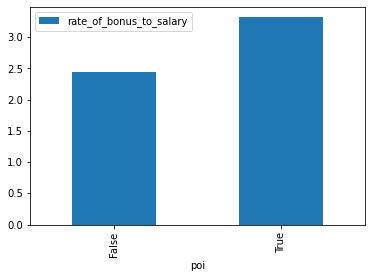

In [40]:
data['rate_of_bonus_to_salary'] = data['bonus']/data['salary']
data.groupby('poi', as_index = False).agg('mean').plot.bar(x='poi', y='rate_of_bonus_to_salary')
plt.show()

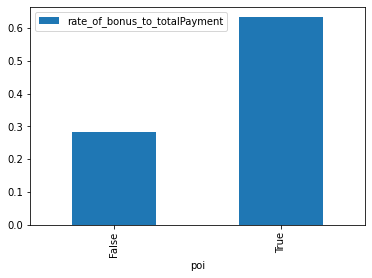

In [41]:
data['rate_of_bonus_to_totalPayment'] = data['bonus']/data['total_payments']
data.groupby('poi', as_index = False).agg('mean').plot.bar(x='poi', y='rate_of_bonus_to_totalPayment')
plt.show()

As we can see from above graphs, two groups indicate obvious differences in ratio of bonus to total payment and ratio of bonus to salary.

Furthermore, my instinct tells me that people who have many email interactions with person of interest have high possibility to also be people of interest. Consequently, I would create three new features to evaluate the level of email interaction that each person has with person of interest.

In [42]:
data['rate_of_from_poi_to_totalEmail']=data['from_poi_to_this_person']/data['to_messages']
data['rate_of_to_poi_to_totalEmail'] = data['from_this_person_to_poi']/data['from_messages']
data['rate_of_from_poi_to_share'] = data['shared_receipt_with_poi']/data['to_messages']
data.drop('name',axis=1,inplace=True)

Conclusion, in this section, five new feautures have been created: rate_of_bonus_to_totalPayment, rate_of_bonus_to_salary, email_address, rate_of_to_poi_to_totalEmail, and rate_of_from_poi_to_totalEmail.

# 4. Feature Selection

Here, except using the features I just created in the previous, I may also need to include other features in the model. In order to decide which feature to contain, I will start conducting feature selection.

But first, let's standardize the whole numeric data since different features have different ranges of values. By standardizing the data, we can make the whole numbers be between 0 and 1. Standardizing the range of numeric data can make the model process more smoothly.

In [43]:
from sklearn.preprocessing import MinMaxScaler
train = data.drop('poi',axis=1).copy()
target = data['poi']

scaler = MinMaxScaler()

train = pd.DataFrame(scaler.fit_transform(train),columns=train.columns)
train.fillna(0,inplace = True)

/Users/tony51307/Library/Python/3.7/lib/python/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


After having the data standardized, I would like to use Random Forest Classifier to exam the importance of each feature.

In [49]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(train.values, target)
feats = pd.Series(data=estimator.feature_importances_, index=train.columns) # display their importance
feats = feats.sort_values(ascending=False)
feats

/Users/tony51307/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rate_of_to_poi_to_totalEmail      0.241131
shared_receipt_with_poi           0.114242
total_stock_value                 0.097581
other                             0.075644
bonus                             0.073409
from_messages                     0.067393
deferred_income                   0.052665
rate_of_from_poi_to_totalEmail    0.047954
rate_of_from_poi_to_share         0.040341
exercised_stock_options           0.033185
restricted_stock                  0.031244
expenses                          0.027284
long_term_incentive               0.024476
total_payments                    0.020809
to_messages                       0.016303
from_this_person_to_poi           0.012478
rate_of_bonus_to_salary           0.011947
from_poi_to_this_person           0.010098
salary                            0.001817
loan_advances                     0.000000
restricted_stock_deferred         0.000000
email_address                     0.000000
director_fees                     0.000000
rate_of_bon

By looking at the resultant feature importance, we can realize that there are a few features (including 'email_address') having no contribution in the predicting process. Therefore, these features should be removed for good.

Moreover, we can discover that 'shared_receipt_with_poi' ranks very high in feature importance. Based on this fact, 'shared_receipt_with_poi' will participate in the model.

Next, instead of picking featurers manually, I would use SelectKBest to decide the top 3 features I must include in the mode.

The f-score value from the SelectKBest means the level of difference in the features between people of interest and normal people. P-value lets us know that how confident we can be to believe that two groups are indeed different. If the f-score is sufficiently high and p-value is lower than 0.05, we can believe this feature has dependence on our target variable.

In [50]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=3)
selector.fit(train, target)
selected_features = selector.transform(train)
print(selected_features.shape)
# 1st way to get the list
vector_names = list(train.columns[selector.get_support(indices=True)])
print(vector_names)

(109, 3)
['exercised_stock_options', 'total_stock_value', 'rate_of_to_poi_to_totalEmail']


In [51]:
select = SelectKBest(k=3).fit(train, target)
bestK = pd.DataFrame()
bestK['F-score'] = select.scores_
bestK['P-value'] = select.pvalues_
bestK.index = train.columns
bestK.sort_values('F-score', ascending= False, inplace=True)
bestK

,F-score,P-value
exercised_stock_options,32.031922,1.282246e-07
total_stock_value,30.224188,2.637152e-07
rate_of_to_poi_to_totalEmail,27.267326,8.781468e-07
salary,23.077020,5.095517e-06
bonus,20.560525,1.513737e-05
rate_of_from_poi_to_share,13.931953,3.055143e-04
rate_of_bonus_to_totalPayment,10.729307,1.421616e-03
restricted_stock,10.515321,1.579257e-03
total_payments,9.672582,2.397500e-03
other,9.358880,2.804542e-03


The result shows that 'rate_of_to_poi_to_totalEmail', 'exercised_stock_options', and 'total_stock_value' are the top 3 features to be in the model. Hence, I would include 'exercised_stock_options' and 'total_stock_value' in the prediction.

In conclusion, 'rate_of_bonus_to_salary','rate_of_from_poi_to_totalEmail', 'rate_of_bonus_to_totalPayment','rate_of_from_poi_to_share', 'rate_of_to_poi_to_totalEmail','shared_receipt_with_poi', and 'exercised_stock_options','total_stock_value' will be implemented in the model.

In [52]:
used_features = ['rate_of_bonus_to_salary','rate_of_from_poi_to_totalEmail',
                 'rate_of_bonus_to_totalPayment','rate_of_from_poi_to_share',
                 'rate_of_to_poi_to_totalEmail','shared_receipt_with_poi',
                 'exercised_stock_options','total_stock_value']
train = train[used_features].copy()


# 5. Tune Hyperparameters  and Train Model

The last thing I am going to do before training the model is to tune the parameters. Here, GridSearchCV will be used to help decide which max_depth and n_estimators can optimize the model.

In [24]:
n_estimators = [100, 200, 300]
max_depth = [1, 3, 5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search = GridSearchCV(estimator, param_grid, scoring="f1", n_jobs=-1, verbose=1)

grid_result = grid_search.fit(train, target)

print("Best F1 score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/Users/tony51307/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best F1 score: 0.355352 using {'max_depth': 3, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    6.6s finished
/Users/tony51307/Library/Python/3.7/lib/python/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


According to the result, the optimal setting is {'max_depth': 3, 'n_estimators': 100}. After knowing that, I can start setting the model and train it.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.25, random_state=4)
estimator = RandomForestClassifier(criterion = 'entropy', max_depth = 3, n_estimators= 100)
estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
print("Acuuracy: ", acc)
print(metrics.classification_report(y_test, y_pred))

Acuuracy:  0.9285714285714286
              precision    recall  f1-score   support

       False       0.93      1.00      0.96        25
        True       1.00      0.33      0.50         3

   micro avg       0.93      0.93      0.93        28
   macro avg       0.96      0.67      0.73        28
weighted avg       0.93      0.93      0.91        28



As we can see above, the resulted model has 1, 0.33, and 0.50 for precision, recall, and f1 score respectively. Precision means how many records that have been considered True are really True. Recall means how many records that are really True have been recognized by the model. Lastly, f1 score is the combination of the precision and recall score. The situations that precision and recall are higher than 0.3 and that f1 is 0.5 suggest that the model is acceptable. The accuracy of 0.9285 is also a good performance.

In turn, this model is utilized further to predict the result of the test data.

In [29]:
# put the whole training data into the model to train
estimator = RandomForestClassifier(max_depth = 3, n_estimators= 100)
estimator.fit(train, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
# modify the test dataset to let it be able to fit in the model
test = pd.read_csv('./ml100/test_features.csv')
name = test['name']
test['rate_of_from_poi_to_totalEmail']=test['from_poi_to_this_person']/test['to_messages']

test['rate_of_to_poi_to_totalEmail'] = test['from_this_person_to_poi']/test['from_messages']

test['rate_of_bonus_to_totalPayment'] =test['bonus']/test['total_payments']

test['rate_of_bonus_to_salary'] = test['bonus']/test['salary']

test['rate_of_from_poi_to_share'] = test['shared_receipt_with_poi']/test['from_messages']

test['rate_stock_options_to_total'] = test['exercised_stock_options']/test['total_stock_value']

test.drop('name', axis=1,inplace=True)
test=test[used_features]
test = pd.DataFrame(scaler.fit_transform(test),columns=test.columns)
test.fillna(0,inplace = True)

# extract the probability of being person of interest
result = estimator.predict_proba(test,)[:,1]

output=pd.DataFrame({'name':name,'poi':result})
output.to_csv('output.csv',index=False)

# 6. Result

## Score: 0.94285 (Top 10%) on Kaggle
